In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import io

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras import layers, Model




%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Dataset1/kddcup1999.csv'

In [4]:
df = pd.read_csv(path)

In [5]:
txt_path = '/content/drive/MyDrive/Dataset1/kddcup1999_columns.txt'

In [6]:
column_types = {}
with open(txt_path, 'r') as file:
    column_labels = file.read()

column_regex = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[1:]:
    match = column_regex.match(column_type)
    column_types[match.group("column_name")] = match.group("data_type").upper()


In [7]:
data = pd.read_csv(path, header=None)

In [8]:
data.drop_duplicates(inplace=True)
data.columns = [*column_types.keys(), "outcome"]

In [9]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,normal.


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1074992 entries, 0 to 4898430
Data columns (total 42 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   duration                     1074992 non-null  int64  
 1   protocol_type                1074992 non-null  object 
 2   service                      1074992 non-null  object 
 3   flag                         1074992 non-null  object 
 4   src_bytes                    1074992 non-null  int64  
 5   dst_bytes                    1074992 non-null  int64  
 6   land                         1074992 non-null  int64  
 7   wrong_fragment               1074992 non-null  int64  
 8   urgent                       1074992 non-null  int64  
 9   hot                          1074992 non-null  int64  
 10  num_failed_logins            1074992 non-null  int64  
 11  logged_in                    1074992 non-null  int64  
 12  num_compromised              1074992 non-n

In [11]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,...,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06,1.074992e+06
mean,1.348908e+02,5.837540e+03,4.873730e+03,2.418623e-05,2.735834e-03,3.627934e-05,5.427947e-02,1.460476e-04,6.301163e-01,3.570817e-02,...,1.619723e+02,1.592091e+02,6.700944e-01,4.949892e-02,9.335762e-02,2.173602e-02,1.906580e-01,1.901296e-01,7.954099e-02,7.829662e-02
std,1.321605e+03,2.009617e+06,1.376866e+06,4.917892e-03,8.835986e-02,1.540162e-02,9.974618e-01,1.558112e-02,4.827732e-01,8.232096e+00,...,1.022645e+02,1.098842e+02,4.259518e-01,1.310801e-01,2.298291e-01,5.636309e-02,3.907621e-01,3.913478e-01,2.621995e-01,2.609840e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,5.000000e+01,1.800000e+01,7.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,0.000000e+00,2.190000e+02,3.320000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,2.240000e+02,2.480000e+02,1.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,0.000000e+00,3.060000e+02,1.721000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,...,2.550000e+02,2.550000e+02,1.000000e+00,6.000000e-02,4.000000e-02,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,5.832900e+04,1.379964e+09,1.309937e+09,1.000000e+00,3.000000e+00,1.400000e+01,7.700000e+01,5.000000e+00,1.000000e+00,7.479000e+03,...,2.550000e+02,2.550000e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [12]:
data.isnull().sum()

duration                       0
protocol_type                  0
service                        0
flag                           0
src_bytes                      0
dst_bytes                      0
land                           0
wrong_fragment                 0
urgent                         0
hot                            0
num_failed_logins              0
logged_in                      0
num_compromised                0
root_shell                     0
su_attempted                   0
num_root                       0
num_file_creations             0
num_shells                     0
num_access_files               0
num_outbound_cmds              0
is_host_login                  0
is_guest_login                 0
count                          0
srv_count                      0
serror_rate                    0
srv_serror_rate                0
rerror_rate                    0
srv_rerror_rate                0
same_srv_rate                  0
diff_srv_rate                  0
srv_diff_h

In [13]:
X = data.drop("outcome", axis=1)

In [14]:
y_binary = (data['outcome'] != 'normal.').astype(int)

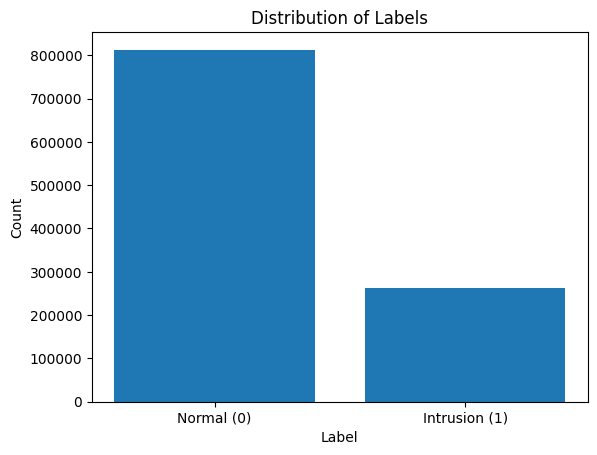

In [15]:
label_counts = y_binary.value_counts()

plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels')
plt.xticks([0, 1], ['Normal (0)', 'Intrusion (1)'])
plt.show()

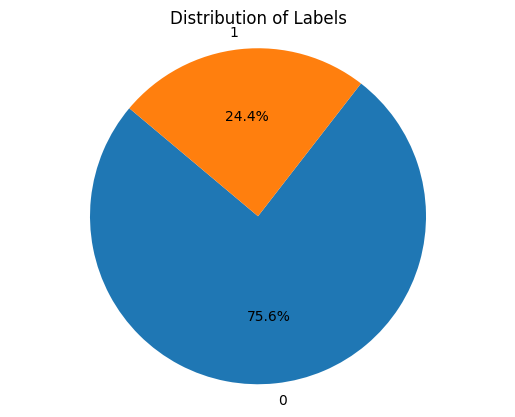

In [16]:
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Labels')
plt.axis('equal')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5)

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

continuous_features = [col for col, col_type in column_types.items() if col_type == 'CONTINUOUS']
categorical_features = [col for col, col_type in column_types.items() if col_type == 'SYMBOLIC']

continuous_transformer = MinMaxScaler()
categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('continuous', continuous_transformer, continuous_features),
        ('categorical', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)

X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)

In [19]:
print("X_train's shape: ", X_train.shape)
print("y_train's shape: ", y_train.shape)
print("X_val's shape: ", X_val.shape)
print("y_val's shape: ", y_val.shape)
print("X_test's shape: ", X_test.shape)
print("y_test's shape: ", y_test.shape)

X_train's shape:  (859993, 126)
y_train's shape:  (859993,)
X_val's shape:  (107500, 126)
y_val's shape:  (107500,)
X_test's shape:  (107499, 126)
X_test's shape:  (107499, 126)


In [20]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        query = self.separate_heads(query, batch_size)
        key = self.separate_heads(key, batch_size)
        value = self.separate_heads(value, batch_size)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output, weights


class TransformerModel(Model):
    def __init__(self, num_heads, ff_dim, num_layers, input_dim, output_dim, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = layers.Dense(input_dim, activation='relu')
        self.attention = MultiHeadSelfAttention(input_dim, num_heads)
        self.ffn = tf.keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(input_dim),]
        )
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)
        self.layer_normal1 = layers.LayerNormalization(epsilon=1e-6)
        self.layer_normal2 = layers.LayerNormalization(epsilon=1e-6)
        self.global_average_pooling = layers.GlobalAveragePooling1D()
        self.fc = layers.Dense(1, activation='sigmoid')

    def call(self, inputs):
        x = self.embedding(inputs)
        x = self.layer_normal1(x + self.dropout1(self.attention(x)[0]))
        x = self.layer_normal2(x + self.dropout2(self.ffn(x)))
        x = self.global_average_pooling(x)
        return self.fc(x)

In [21]:
num_heads = 2
ff_dim = 128
num_layers = 2
input_dim = X_train.shape[1]
output_dim = 1
dropout_rate = 0.2

model_trans_bin = TransformerModel(num_heads, ff_dim, num_layers, input_dim, output_dim)

loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model_trans_bin.compile(optimizer=optimizer, loss=loss_fn)

In [22]:
model_trans_bin.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/10
13438/13438 [==============================] - 866s 64ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 2/10
13438/13438 [==============================] - 794s 59ms/step - loss: 0.0045 - val_loss: 0.0041
Epoch 3/10
13438/13438 [==============================] - 791s 59ms/step - loss: 0.0036 - val_loss: 0.0030
Epoch 4/10
13438/13438 [==============================] - 822s 61ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 5/10
13438/13438 [==============================] - 790s 59ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/10
13438/13438 [==============================] - 785s 58ms/step - loss: 0.0026 - val_loss: 0.0026
Epoch 7/10
13438/13438 [==============================] - 779s 58ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/10
13438/13438 [==============================] - 813s 61ms/step - loss: 0.0023 - val_loss: 0.0025
Epoch 9/10
13438/13438 [==============================] - 806s 60ms/step - loss: 0.0022 - val_loss: 0.0024
Epoch 10/10
13438/13438 [============

In [23]:
loss = pd.DataFrame(model_trans_bin.history.history)

<Axes: >

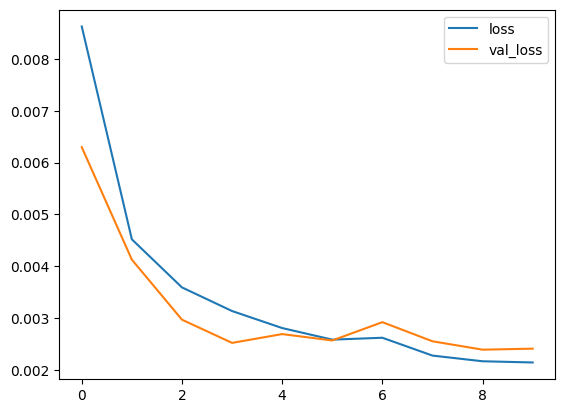

In [24]:
loss.plot()

In [25]:
model_trans_bin.save("name.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


NotImplementedError: Saving the model to HDF5 format requires the model to be a Functional model or a Sequential model. It does not work for subclassed models, because such models are defined via the body of a Python method, which isn't safely serializable. Consider saving to the Tensorflow SavedModel format (by setting save_format="tf") or using `save_weights`.

In [26]:
y_pred_prob = model_trans_bin.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

3360/3360 [==============================] - 27s 8ms/step


In [28]:
print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9997    0.9995     81419
           1     0.9990    0.9981    0.9985     26080

    accuracy                         0.9993    107499
   macro avg     0.9992    0.9989    0.9990    107499
weighted avg     0.9993    0.9993    0.9993    107499

